# Hydrogen Systems

This tutorial covers hydrogen integration in PyPSA-GB, including electrolysis, storage, and hydrogen-to-power.

## What You'll Learn

- Hydrogen system components
- Electrolysis operation patterns
- Hydrogen storage dynamics
- Hydrogen-to-power generation
- System integration and flexibility

## 1. Setup

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
from pyproj import Transformer

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

colors = {
    'electrolysis': '#00BCD4', 'hydrogen_storage': '#009688', 'H2_CCGT': '#8BC34A',
    'H2_turbine': '#CDDC39', 'fuel_cell': '#4CAF50', 'hydrogen': '#26A69A'
}

print(f"PyPSA version: {pypsa.__version__}")

PyPSA version: 1.0.7


## 2. Load Network

In [2]:
# Load a future scenario with hydrogen
n = pypsa.Network("../../../resources/network/EE50_clustered_solved.nc")

print(f"Network loaded")
print(f"  Snapshots: {len(n.snapshots)}")
print(f"  Buses: {len(n.buses)}")
print(f"  Links: {len(n.links)}")
print(f"  Stores: {len(n.stores)}")

INFO:pypsa.network.io:Imported network 'EE50_clustered (Clustered)' has buses, carriers, generators, lines, links, loads, storage_units, stores, sub_networks


Network loaded
  Snapshots: 168
  Buses: 110
  Links: 193
  Stores: 1


## 3. Hydrogen System Components

The hydrogen system typically includes:
- **Electrolyzers**: Convert electricity to hydrogen (power-to-gas)
- **Hydrogen Storage**: Store hydrogen (underground caverns, tanks)
- **H2 Turbines/Fuel Cells**: Convert hydrogen back to electricity
- **Hydrogen Buses**: Represent the hydrogen "network"

In [3]:
from IPython.display import display

# Identify hydrogen components (robust detection)
print("=== Hydrogen System Components (robust detection) ===")

# Patterns
pat_elec = r'electrolys|electrolyser|electrolysis|p2g|power_to_gas'
pat_h2 = r'h2|hydrogen|fuel.*cell|h2.*power|hydrogen.*power|H2_CCGT|H2_turbine|fuel_cell'

# Hydrogen buses (by carrier or index)
h2_buses = n.buses[
    n.buses.carrier.str.contains('H2|hydrogen', case=False, na=False) |
    n.buses.index.str.contains(pat_h2, case=False, na=False)
]
print(f"\nHydrogen Buses: {len(h2_buses)}")
if len(h2_buses):
    display(h2_buses.head(5))

# Electrolyzers (links by carrier or index)
electrolyzers = n.links[
    n.links.carrier.str.contains(pat_elec, case=False, na=False) |
    n.links.index.str.contains(pat_elec, case=False, na=False)
]
print(f"Electrolyzers: {len(electrolyzers)}")
if len(electrolyzers):
    display(electrolyzers[['carrier', 'bus0', 'bus1', 'p_nom']].head(10))

# H2 links (links by carrier or index)
h2_power_links = n.links[
    n.links.carrier.str.contains(pat_h2, case=False, na=False) |
    n.links.index.str.contains(pat_h2, case=False, na=False)
]
print(f"H2-to-Power Links: {len(h2_power_links)}")
if len(h2_power_links):
    display(h2_power_links[['carrier', 'bus0', 'bus1', 'p_nom']].head(10))

# Hydrogen storage (stores by carrier or index)
h2_stores = n.stores[
    n.stores.carrier.str.contains('H2|hydrogen', case=False, na=False) |
    n.stores.index.str.contains(pat_h2, case=False, na=False)
]
print(f"Hydrogen Stores: {len(h2_stores)}")
if len(h2_stores):
    display(h2_stores[['carrier', 'bus', 'e_nom']].head(10))

# Fallback: show top carriers for manual inspection if none found
if (len(h2_power_links) == 0 and len(h2_generators) == 0 and len(electrolyzers) == 0 and len(h2_stores) == 0):
    print("\nNo obvious hydrogen components detected. Top link/generator/store carriers (for manual inspection):")
    print("\nTop link carriers:")
    print(n.links['carrier'].value_counts().head(20))
    print("\nTop generator carriers:")
    print(n.generators['carrier'].value_counts().head(20))
    print("\nTop store carriers:")
    print(n.stores['carrier'].value_counts().head(20))

=== Hydrogen System Components (robust detection) ===

Hydrogen Buses: 1


,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,lon,lat,country,x_osgb36,y_osgb36
name,,,,,,,,,,,,,,,,,,
external__GB_H2,1.0,,458765.256275,380314.19242,H2_gas,,,1.0,0.0,inf,Slack,,10,-1.119362,53.316507,,458765.255406,380314.192756


Electrolyzers: 22


,carrier,bus0,bus1,p_nom
name,,,,
electrolysis_ABBA1-,electrolysis,cluster_71,external__GB_H2,5522.035639
electrolysis_BLHI4-,electrolysis,cluster_26,external__GB_H2,995.848625
electrolysis_BONB4-,electrolysis,cluster_25,external__GB_H2,995.848625
electrolysis_BRFO41,electrolysis,cluster_34,external__GB_H2,1549.097861
electrolysis_BRLE41,electrolysis,cluster_22,external__GB_H2,1217.148320
electrolysis_CANT41,electrolysis,cluster_78,external__GB_H2,1327.798167
electrolysis_CONQ41,electrolysis,cluster_75,external__GB_H2,1106.498472
electrolysis_CREB41,electrolysis,cluster_16,external__GB_H2,1217.148320
electrolysis_DRAK41,electrolysis,cluster_9,external__GB_H2,995.848625


H2-to-Power Links: 155


,carrier,bus0,bus1,p_nom
name,,,,
H2_turbine_gen_H2_1253,H2_turbine,external__GB_H2,cluster_71,27.331
H2_turbine_gen_H2_1254,H2_turbine,external__GB_H2,cluster_71,77.359
H2_turbine_gen_H2_1255,H2_turbine,external__GB_H2,cluster_71,33.772
H2_turbine_gen_H2_1256,H2_turbine,external__GB_H2,cluster_71,0.455
H2_turbine_gen_H2_1257,H2_turbine,external__GB_H2,cluster_71,49.510
H2_turbine_gen_H2_1258,H2_turbine,external__GB_H2,cluster_71,84.894
H2_turbine_gen_H2_1259,H2_turbine,external__GB_H2,cluster_71,59.833
H2_turbine_gen_H2_1260,H2_turbine,external__GB_H2,cluster_71,53.595
H2_turbine_gen_H2_1261,H2_turbine,external__GB_H2,cluster_71,126.926


Hydrogen Stores: 1


,carrier,bus,e_nom
name,,,
GB_H2_storage,H2_gas,external__GB_H2,4623381.84


In [4]:
# Show all link and store carriers to identify H2 components
print("\nAll Link Carriers:")
print(n.links['carrier'].value_counts())

print("\nAll Store Carriers:")
print(n.stores['carrier'].value_counts())

print("\nAll Generator Carriers:")
print(n.generators['carrier'].value_counts())


All Link Carriers:
carrier
H2_turbine      155
electrolysis     22
DC               13
AC                3
Name: count, dtype: int64

All Store Carriers:
carrier
H2_gas    1
Name: count, dtype: int64

All Generator Carriers:
carrier
load_shedding       2498
solar_pv             590
wind_onshore         548
biogas               384
landfill_gas         268
biomass              231
CHP                  190
waste_to_energy      176
large_hydro          168
wind_offshore         39
advanced_biofuel      28
CCGT                  20
OCGT                  20
gas_engine            20
nuclear               20
sewage_gas            12
marine                10
EU_import              9
oil                    3
geothermal             1
Name: count, dtype: int64


## 4. Electrolyzer Capacity and Operation

In [5]:
# Electrolyzer capacity
if len(electrolyzers) > 0:
    total_capacity = electrolyzers['p_nom'].sum() / 1000  # GW
    print(f"Total Electrolyzer Capacity: {total_capacity:.2f} GW")
    
    # Efficiency
    if 'efficiency' in electrolyzers.columns:
        avg_eff = electrolyzers['efficiency'].mean() * 100
        print(f"Average Efficiency: {avg_eff:.1f}%")
else:
    print("No electrolyzers found in the network")

Total Electrolyzer Capacity: 28.95 GW
Average Efficiency: 70.0%


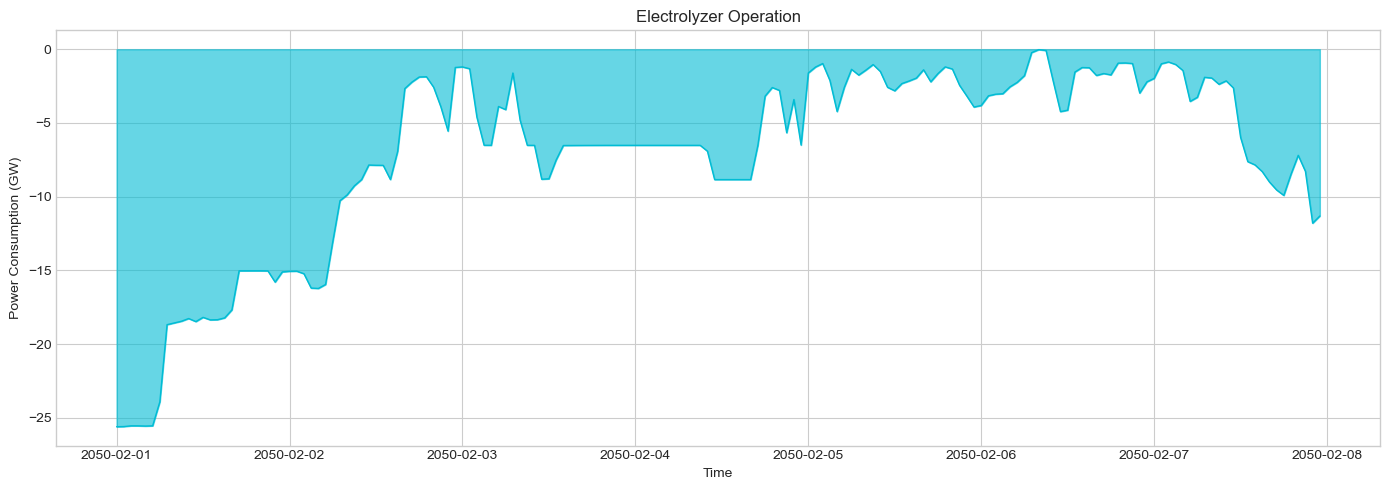


Statistics:
  Peak demand: -0.02 GW
  Average demand: -7.10 GW
  Total H2 production: -1192.6 GWh_e


In [6]:
# Electrolyzer operation
if len(electrolyzers) > 0 and len(n.links_t.p0.columns) > 0:
    elec_cols = [c for c in electrolyzers.index if c in n.links_t.p0.columns]
    if elec_cols:
        elec_power = n.links_t.p0[elec_cols].sum(axis=1) / 1000  # GW (negative = consuming)
        
        fig, ax = plt.subplots(figsize=(14, 5))
        
        ax.fill_between(elec_power.index, -elec_power, alpha=0.6, color=colors['electrolysis'])
        ax.plot(elec_power.index, -elec_power, color=colors['electrolysis'], linewidth=1)
        
        ax.set_ylabel('Power Consumption (GW)')
        ax.set_xlabel('Time')
        ax.set_title('Electrolyzer Operation')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nStatistics:")
        print(f"  Peak demand: {-elec_power.min():.2f} GW")
        print(f"  Average demand: {-elec_power.mean():.2f} GW")
        print(f"  Total H2 production: {-elec_power.sum():.1f} GWh_e")

## 5. Hydrogen Storage

In [7]:
# Hydrogen storage capacity
if len(h2_stores) > 0:
    total_energy = h2_stores['e_nom'].sum() / 1000  # GWh
    print(f"Total H2 Storage Energy Capacity: {total_energy:.1f} GWh")
    
    # Storage parameters
    print("\nStorage Parameters:")
    for store in h2_stores.index[:5]:  # Show first 5
        print(f"  {store}: {h2_stores.loc[store, 'e_nom']/1000:.1f} GWh")
else:
    print("No hydrogen storage found")

Total H2 Storage Energy Capacity: 4623.4 GWh

Storage Parameters:
  GB_H2_storage: 4623.4 GWh


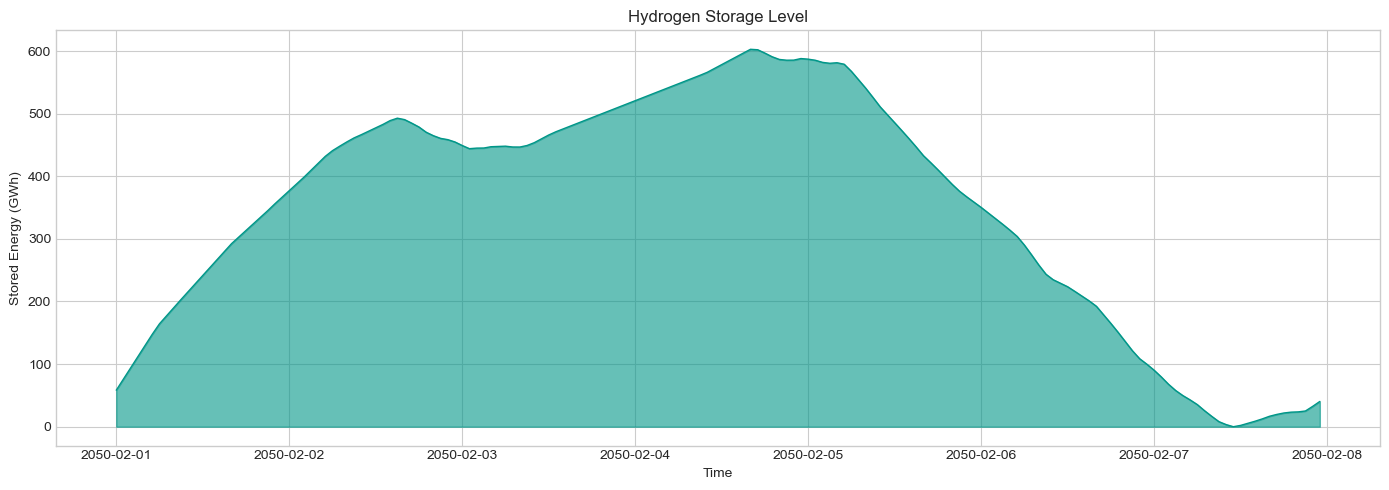


Storage Statistics:
  Max level: 602.9 GWh
  Min level: 0.0 GWh
  Average: 352.3 GWh


In [8]:
# Hydrogen storage state
if len(h2_stores) > 0 and len(n.stores_t.e.columns) > 0:
    h2_store_cols = [c for c in h2_stores.index if c in n.stores_t.e.columns]
    if h2_store_cols:
        h2_soe = n.stores_t.e[h2_store_cols].sum(axis=1) / 1000  # GWh
        
        fig, ax = plt.subplots(figsize=(14, 5))
        
        ax.fill_between(h2_soe.index, h2_soe, alpha=0.6, color=colors['hydrogen_storage'])
        ax.plot(h2_soe.index, h2_soe, color=colors['hydrogen_storage'], linewidth=1)
        
        ax.set_ylabel('Stored Energy (GWh)')
        ax.set_xlabel('Time')
        ax.set_title('Hydrogen Storage Level')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nStorage Statistics:")
        print(f"  Max level: {h2_soe.max():.1f} GWh")
        print(f"  Min level: {h2_soe.min():.1f} GWh")
        print(f"  Average: {h2_soe.mean():.1f} GWh")

## 6. Hydrogen-to-Power Generation

H2-to-Power Capacity (links): 27.52 GW


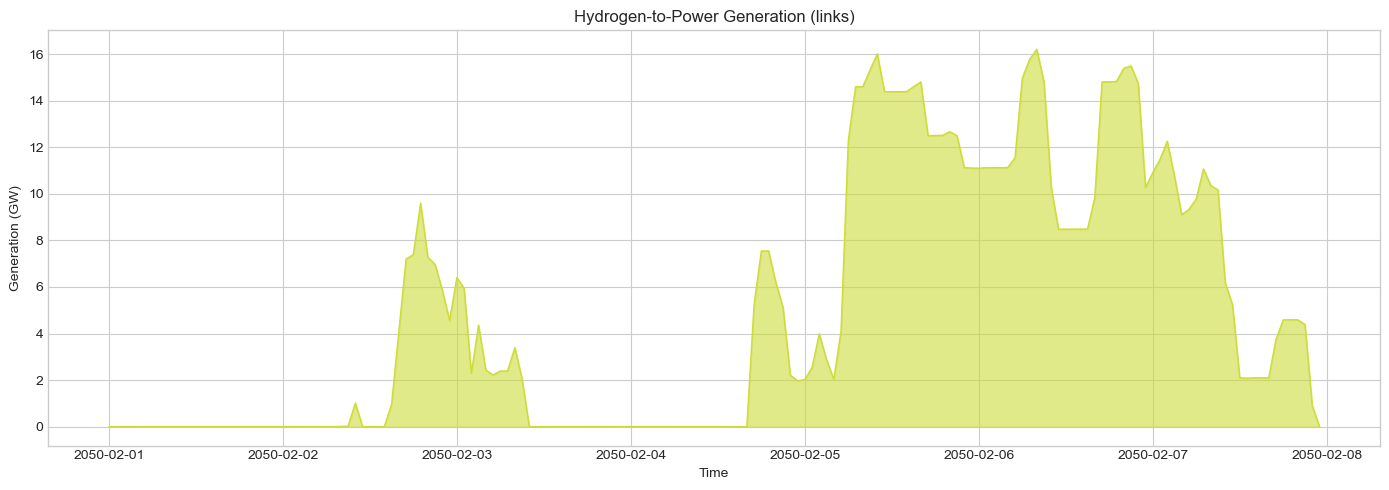


Generation Statistics (links):
  Peak generation: 16.21 GW
  Average generation: 4.93 GW
  Capacity factor: 17.9%

Top H2-to-Power links (GW):
name
H2_turbine_FES_H2_BRFO41    1.472787
H2_turbine_FES_H2_WALP41    1.367588
H2_turbine_FES_H2_GRAI41    1.367588
H2_turbine_FES_H2_HUNE4-    1.262389
H2_turbine_FES_H2_CANT41    1.262389
H2_turbine_FES_H2_CREB41    1.157190
H2_turbine_FES_H2_BRLE41    1.157190
H2_turbine_FES_H2_TILB41    1.157190
H2_turbine_FES_H2_NORM41    1.157190
H2_turbine_FES_H2_WIYH1-    1.051991
Name: p_nom, dtype: float64


In [9]:
# H2-to-power capacity and generation — prefer plotting `h2_power_links`
# If link-based H2-to-power exists, use those links explicitly in the plot (fallback to generators).
if len(h2_power_links) > 0:
    total_capacity = h2_power_links['p_nom'].sum() / 1000  # GW
    print(f"H2-to-Power Capacity (links): {total_capacity:.2f} GW")

    # Select links that have timeseries
    h2_cols = [c for c in h2_power_links.index if c in n.links_t.p0.columns]
    if h2_cols:
        # For links, positive values in p0 usually indicate flow from bus0->bus1.
        # We clip to positive values to capture electrical output direction and sum contributions.
        h2_gen = n.links_t.p0[h2_cols].clip(lower=0).sum(axis=1) / 1000  # GW

        fig, ax = plt.subplots(figsize=(14, 5))

        color = colors.get('H2_turbine', colors.get('H2_CCGT', '#8BC34A'))
        ax.fill_between(h2_gen.index, h2_gen, alpha=0.6, color=color)
        ax.plot(h2_gen.index, h2_gen, color=color, linewidth=1)

        ax.set_ylabel('Generation (GW)')
        ax.set_xlabel('Time')
        ax.set_title('Hydrogen-to-Power Generation (links)')

        plt.tight_layout()
        plt.show()

        print(f"\nGeneration Statistics (links):")
        print(f"  Peak generation: {h2_gen.max():.2f} GW")
        print(f"  Average generation: {h2_gen.mean():.2f} GW")
        if total_capacity > 0:
            print(f"  Capacity factor: {h2_gen.mean()/total_capacity*100:.1f}%")

        # Show top contributing links by name and capacity
        top_links = n.links.loc[h2_cols, 'p_nom'].sort_values(ascending=False) / 1000
        print('\nTop H2-to-Power links (GW):')
        print(top_links.head(10))
    else:
        print("H2-to-power links found but no matching timeseries in `n.links_t.p0`.")
        if len(h2_generators) > 0:
            print("Falling back to H2 generators for time series plot.")
            # Fallback to generators code below
            h2_cols = [c for c in h2_generators.index if c in n.generators_t.p.columns]
            if h2_cols:
                h2_gen = n.generators_t.p[h2_cols].sum(axis=1) / 1000
                fig, ax = plt.subplots(figsize=(14, 5))
                ax.fill_between(h2_gen.index, h2_gen, alpha=0.6, color=colors.get('H2_CCGT', '#8BC34A'))
                ax.plot(h2_gen.index, h2_gen, color=colors.get('H2_CCGT', '#8BC34A'), linewidth=1)
                ax.set_ylabel('Generation (GW)')
                ax.set_xlabel('Time')
                ax.set_title('Hydrogen-to-Power Generation (generators fallback)')
                plt.tight_layout(); plt.show()
                print(f"\nGeneration Statistics (generators fallback):")
                print(f"  Peak generation: {h2_gen.max():.2f} GW")
                print(f"  Average generation: {h2_gen.mean():.2f} GW")
                if h2_generators['p_nom'].sum() > 0:
                    print(f"  Capacity factor: {h2_gen.mean()/(h2_generators['p_nom'].sum()/1000)*100:.1f}%")
        else:
            print("No H2 generation timeseries available to plot.")

elif len(h2_generators) > 0:
    # No links; use generators if available
    total_capacity = h2_generators['p_nom'].sum() / 1000  # GW
    print(f"H2-to-Power Capacity (generators): {total_capacity:.2f} GW")

    h2_cols = [c for c in h2_generators.index if c in n.generators_t.p.columns]
    if h2_cols:
        h2_gen = n.generators_t.p[h2_cols].sum(axis=1) / 1000  # GW

        fig, ax = plt.subplots(figsize=(14, 5))

        ax.fill_between(h2_gen.index, h2_gen, alpha=0.6, color=colors.get('H2_CCGT', '#8BC34A'))
        ax.plot(h2_gen.index, h2_gen, color=colors.get('H2_CCGT', '#8BC34A'), linewidth=1)

        ax.set_ylabel('Generation (GW)')
        ax.set_xlabel('Time')
        ax.set_title('Hydrogen-to-Power Generation')

        plt.tight_layout()
        plt.show()

        print(f"\nGeneration Statistics:")
        print(f"  Peak generation: {h2_gen.max():.2f} GW")
        print(f"  Average generation: {h2_gen.mean():.2f} GW")
        if total_capacity > 0:
            print(f"  Capacity factor: {h2_gen.mean()/total_capacity*100:.1f}%")
    else:
        print("H2 generators found but no matching timeseries in `n.generators_t.p`.")
else:
    print("No H2-to-power links or H2 generators found")

## 7. Hydrogen System as Flexibility Provider

Correlation: -0.777


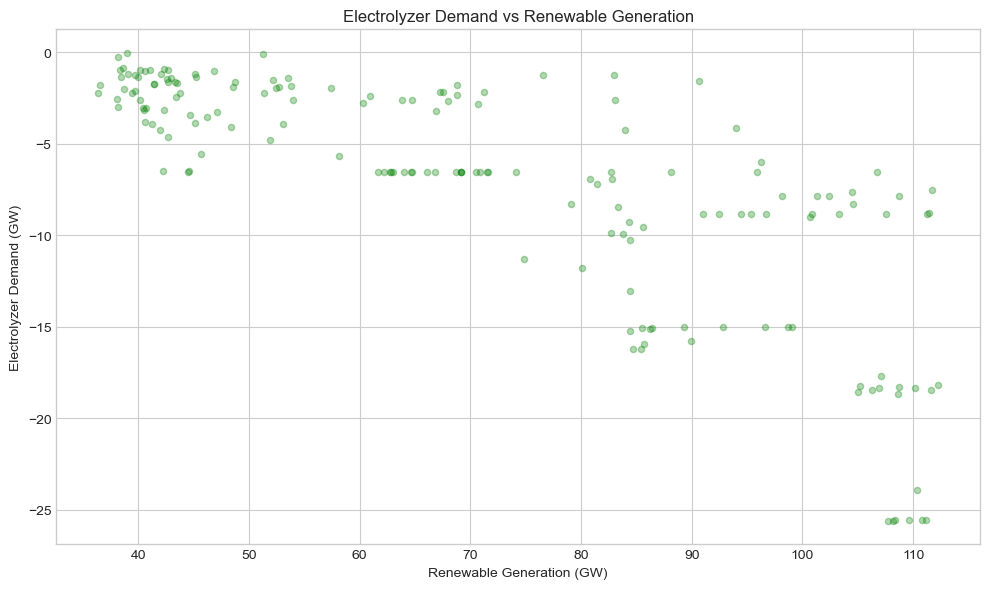

In [10]:
# Compare electrolyzer consumption with renewable generation
renewable_carriers = ['wind_onshore', 'wind_offshore', 'solar_pv']
renewable_gens = n.generators[n.generators.carrier.isin(renewable_carriers)].index
renewable_gens = renewable_gens[renewable_gens.isin(n.generators_t.p.columns)]

if len(renewable_gens) > 0 and len(electrolyzers) > 0:
    renewable_gen = n.generators_t.p[renewable_gens].sum(axis=1) / 1000  # GW
    
    elec_cols = [c for c in electrolyzers.index if c in n.links_t.p0.columns]
    if elec_cols:
        elec_demand = -n.links_t.p0[elec_cols].sum(axis=1) / 1000  # GW (positive)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        ax.scatter(renewable_gen, elec_demand, alpha=0.3, s=20, c='green')
        
        ax.set_xlabel('Renewable Generation (GW)')
        ax.set_ylabel('Electrolyzer Demand (GW)')
        ax.set_title('Electrolyzer Demand vs Renewable Generation')
        
        corr = renewable_gen.corr(elec_demand)
        print(f"Correlation: {corr:.3f}")
        
        plt.tight_layout()
        plt.show()